In [ ]:
import os

import pandas as pd          # for data manipulation
import matplotlib.pyplot as plt  # for plotting graphs
import seaborn as sns        # for advanced plotting and heatmaps

In [ ]:
data_path = "/content/CMAPSSData"

def load_cmapss_dataset(dataset_number):
    """Load all files for a specific CMAPSS dataset (1-4)"""
    base_name = f"FD00{dataset_number}"
    train_file = os.path.join(data_path, f'train_{base_name}.txt')
    test_file = os.path.join(data_path, f'test_{base_name}.txt')
    rul_file = os.path.join(data_path, f'RUL_{base_name}.txt')

    columns = ['unit_number', 'time_cycles'] + \
              [f'operational_setting_{i}' for i in range(1,4)] + \
              [f'sensor_measurement_{i}' for i in range(1,22)]

    train = pd.read_csv(train_file, sep='\s+', header=None, names=columns)
    test = pd.read_csv(test_file, sep='\s+', header=None, names=columns)
    rul = pd.read_csv(rul_file, sep='\s+', header=None, names=['RUL'])

    return train, test, rul

# Load all datasets
datasets = {i: load_cmapss_dataset(i) for i in range(1, 5)}
datasets

In [ ]:
def analyze_dataset(dataset_num, train, test, rul=None):
    """
    Analyze and visualize key statistics and trends in CMAPSS dataset FD00{dataset_num}.

    Parameters:
        dataset_num (int): Dataset number (1-4).
        train (pd.DataFrame): Training data with sensor and cycle info.
        test (pd.DataFrame): Test data (not used here but printed).
        rul (pd.DataFrame or None): Optional RUL info, currently unused.

    Returns:
        pd.DataFrame: Training data augmented with RUL column.
    """

    print(f"\n{'='*50}")
    print(f"Analysis for FD00{dataset_num}")
    print(f"{'='*50}")
    print(f"\nTraining data: {train.shape[0]} records, {train['unit_number'].nunique()} engines")
    print(f"Test data: {test.shape[0]} records, {test['unit_number'].nunique()} engines")

    # Add RUL columns
    def add_rul(df):
        max_cycle = df.groupby('unit_number')['time_cycles'].max()
        return df.merge(max_cycle.to_frame(name='max_cycle'), on='unit_number').assign(
            RUL=lambda x: x['max_cycle'] - x['time_cycles']).drop('max_cycle', axis=1)

    train = add_rul(train)

    # Engine lifetime distribution
    engine_life = train.groupby('unit_number')['time_cycles'].max()
    plt.figure(figsize=(10, 5))
    sns.histplot(engine_life, bins=30, kde=True)
    plt.title(f'Engine Lifetime Distribution (FD00{dataset_num})')
    plt.xlabel('Total Cycles Before Failure')
    plt.ylabel('Count')
    plt.show()

    # Sensor correlation with RUL
    sensors = [f'sensor_measurement_{i}' for i in range(1, 22)]
    corr_matrix = train[sensors + ['RUL']].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix[['RUL']].sort_values('RUL', ascending=False),
                annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Sensor Correlation with RUL (FD00{dataset_num})')
    plt.show()

    # Operational settings distribution
    settings = [f'operational_setting_{i}' for i in range(1, 4)]
    train[settings].hist(bins=30, figsize=(15, 5))
    plt.suptitle(f'Operational Settings Distribution (FD00{dataset_num})')
    plt.tight_layout()
    plt.show()

    # Sensor degradation trends
    sample_engine = train['unit_number'].iloc[0]
    sensor_cols = sensors[:6]  # First 6 sensors for visualization
    engine_data = train[train['unit_number'] == sample_engine]

    plt.figure(figsize=(15, 8))
    for col in sensor_cols:
        plt.plot(engine_data['time_cycles'], engine_data[col], label=col)
    plt.xlabel('Time Cycles')
    plt.ylabel('Sensor Value')
    plt.title(f'Sensor Trends for Engine {sample_engine} (FD00{dataset_num})')
    plt.legend()
    plt.show()

    return train


Analysis for FD001

Training data: 20631 records, 100 engines
Test data: 13096 records, 100 engines


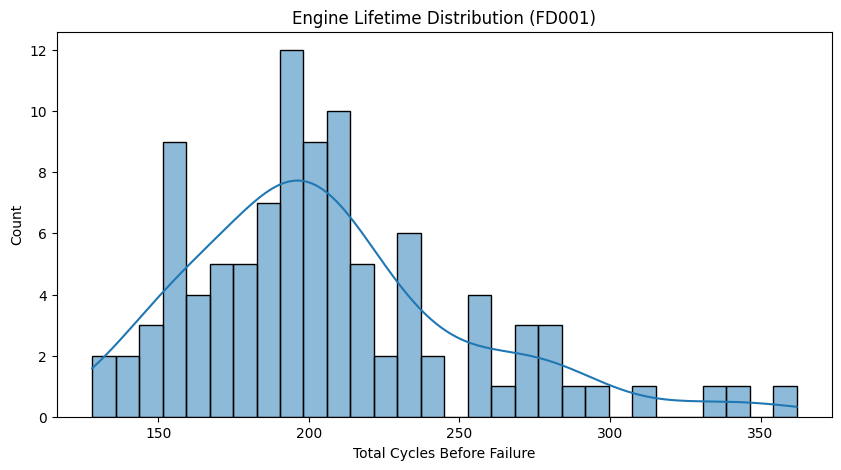

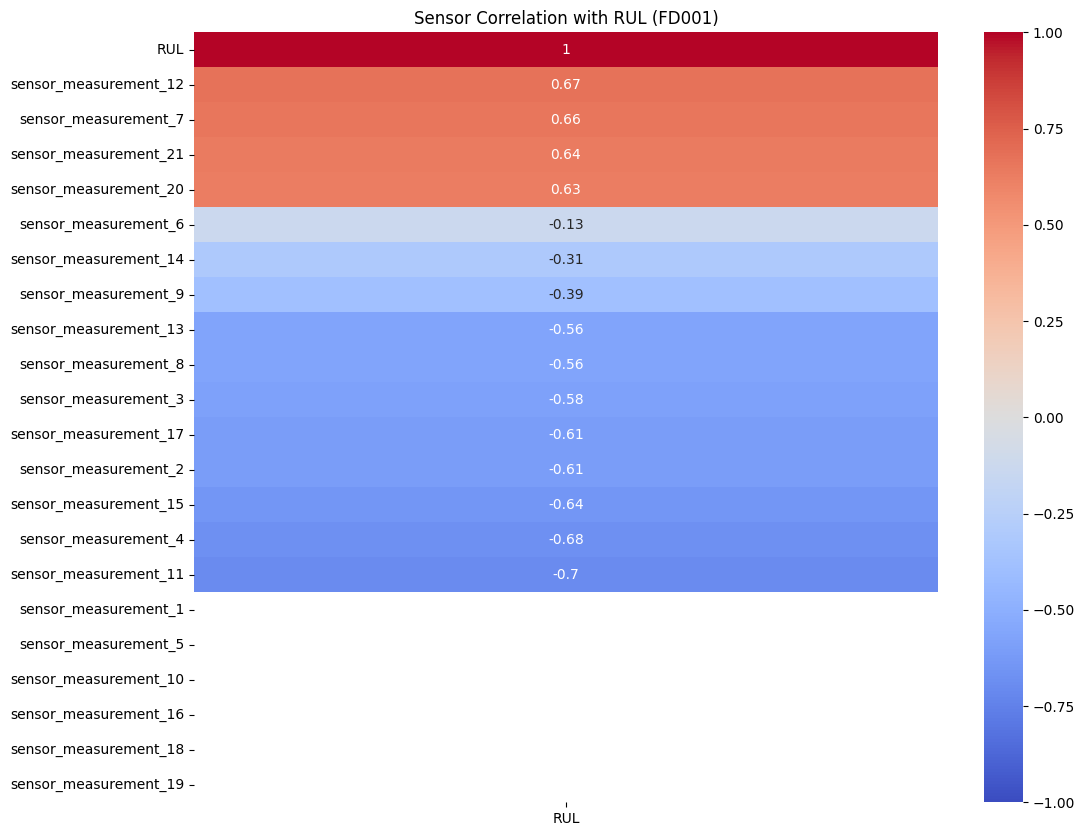

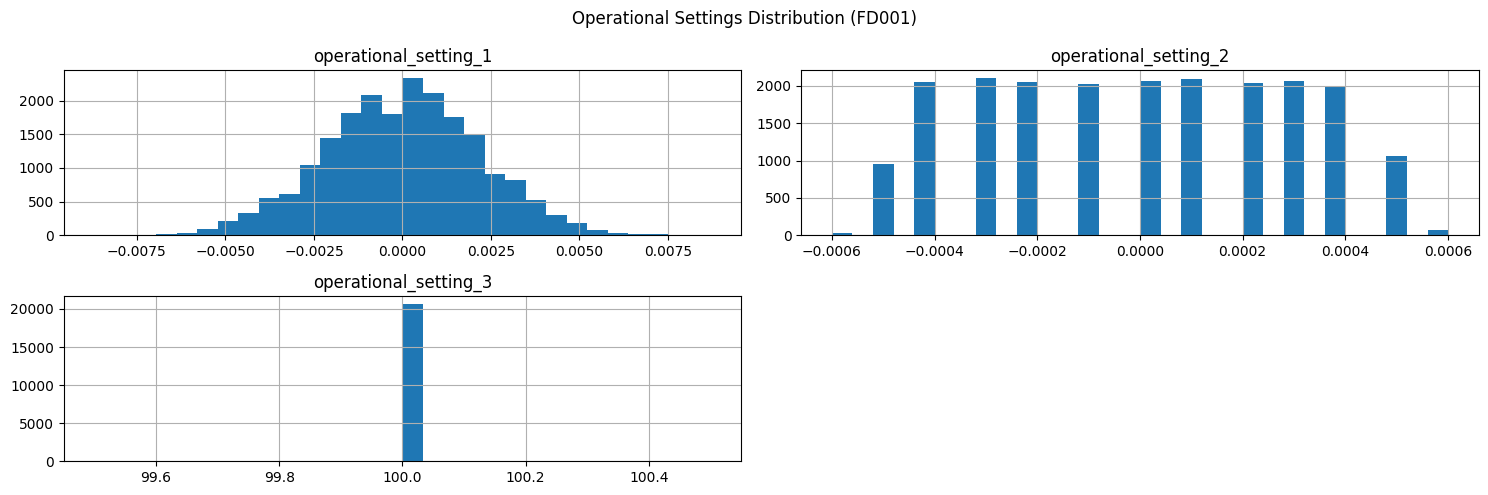

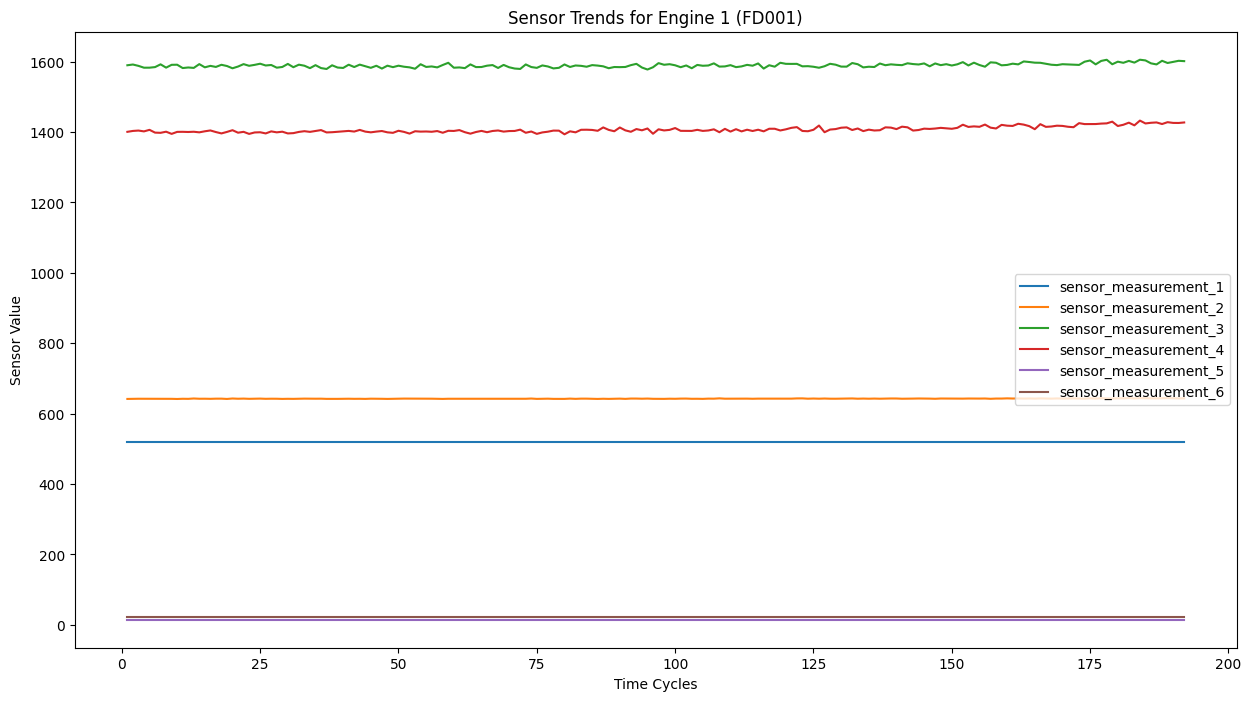


Analysis for FD002

Training data: 53759 records, 260 engines
Test data: 33991 records, 259 engines


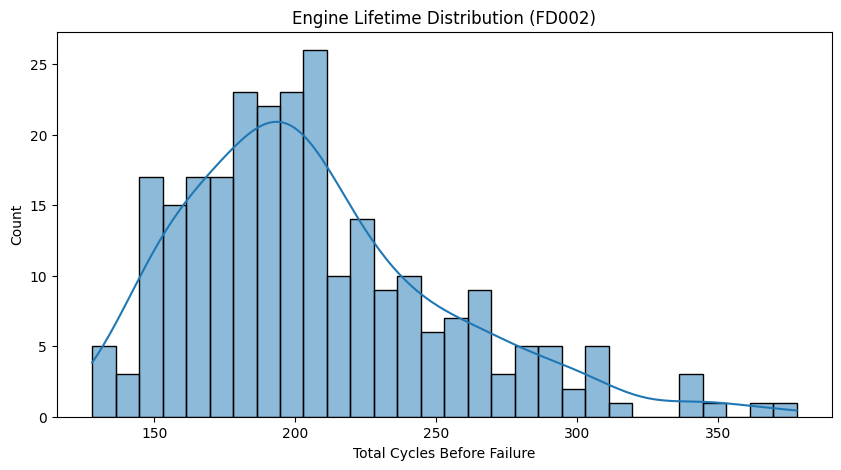

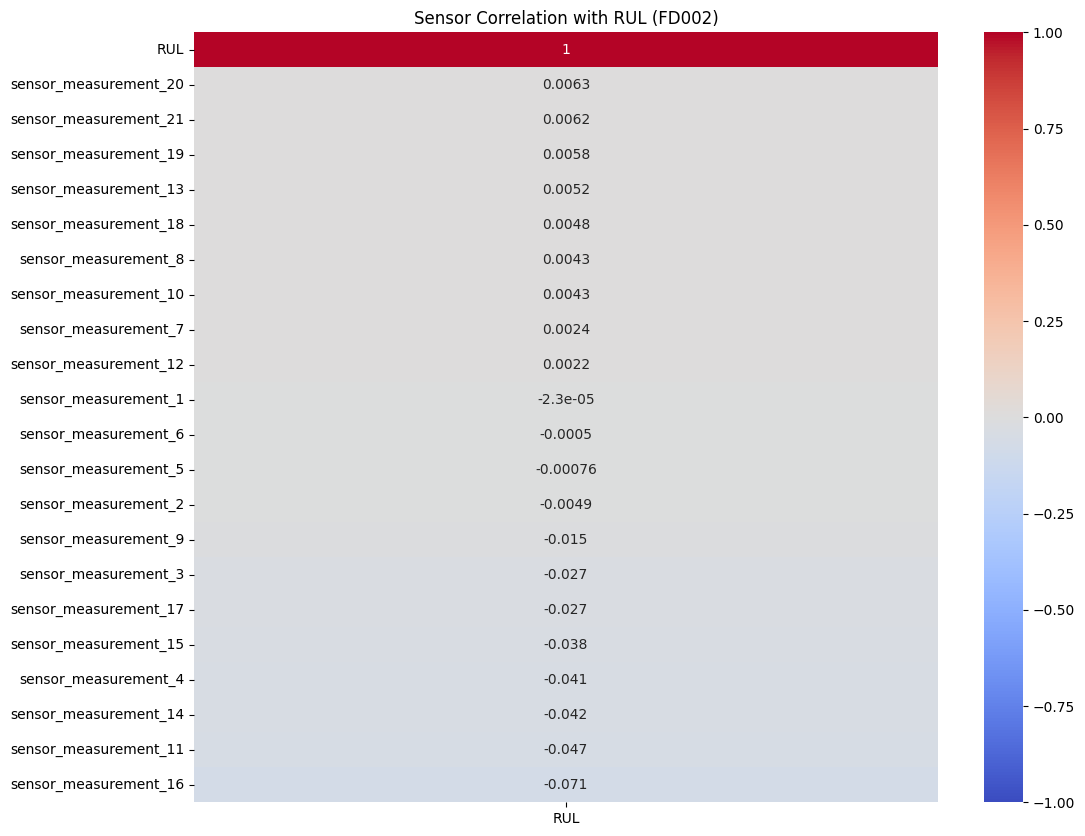

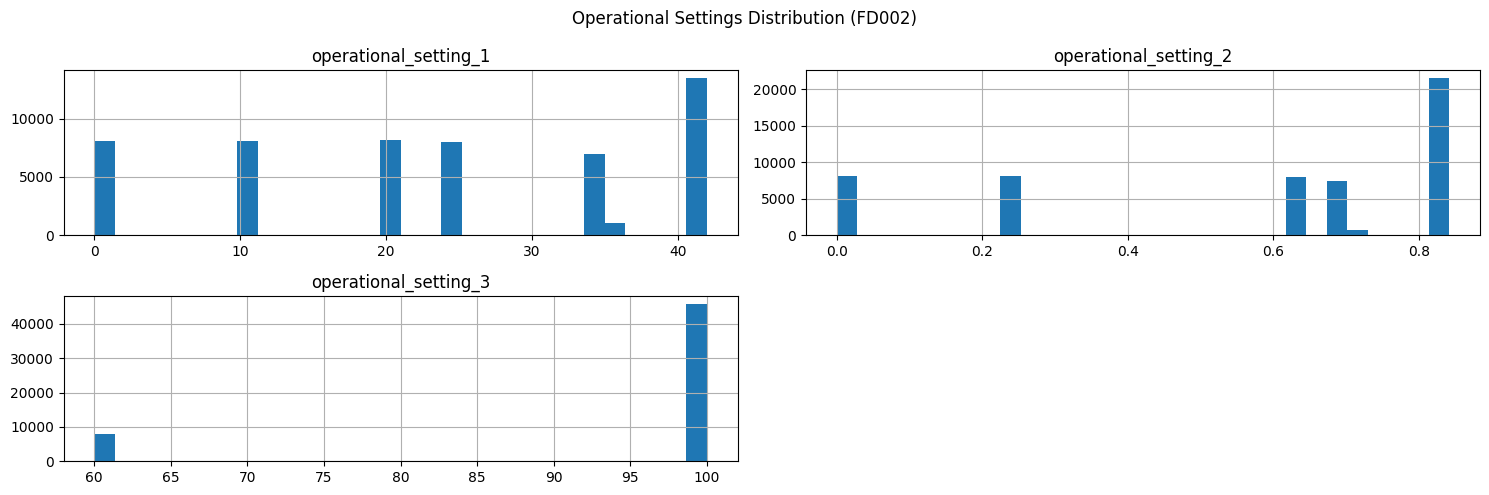

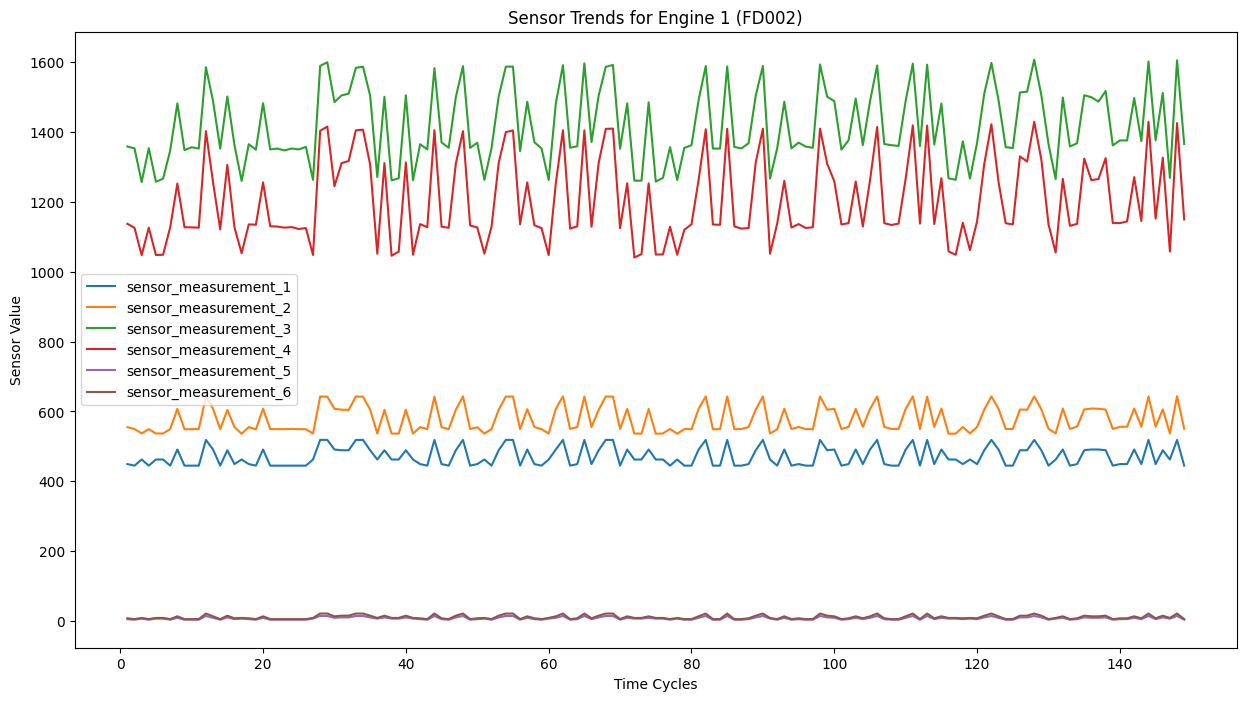


Analysis for FD003

Training data: 24720 records, 100 engines
Test data: 16596 records, 100 engines


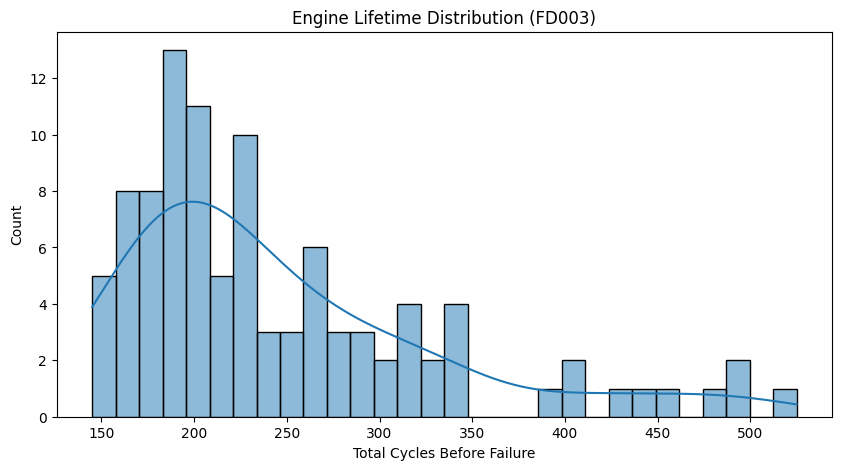

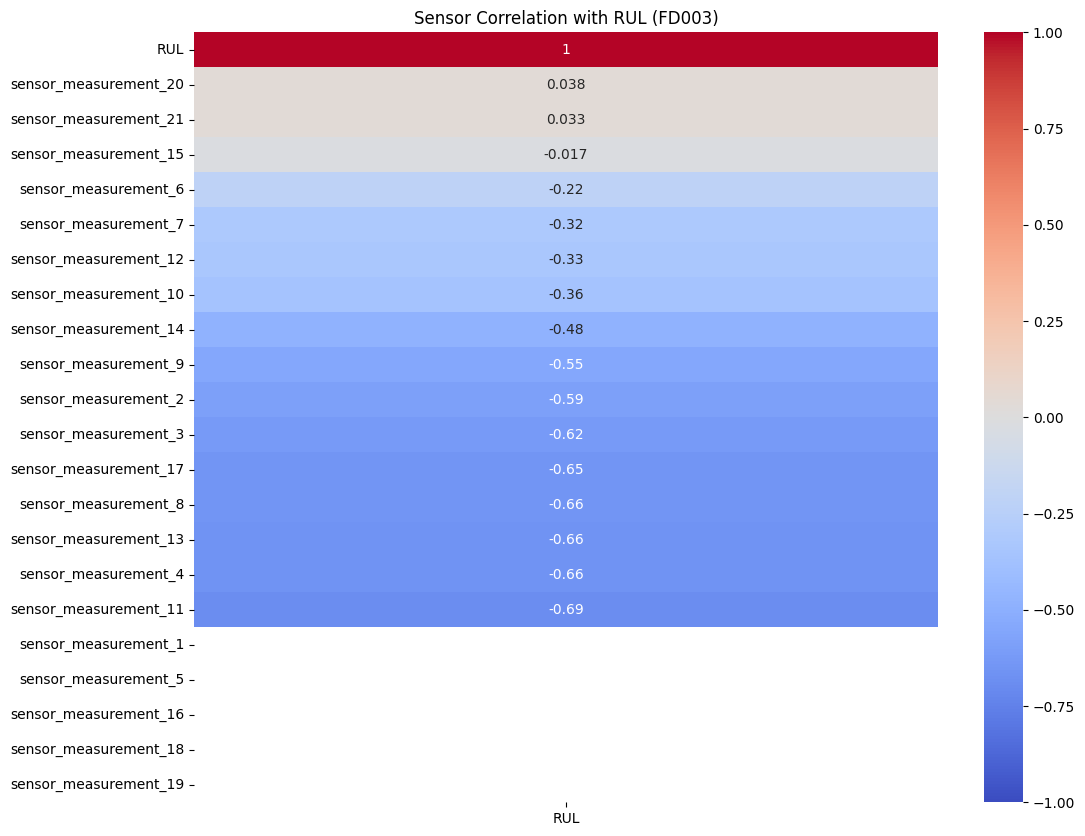

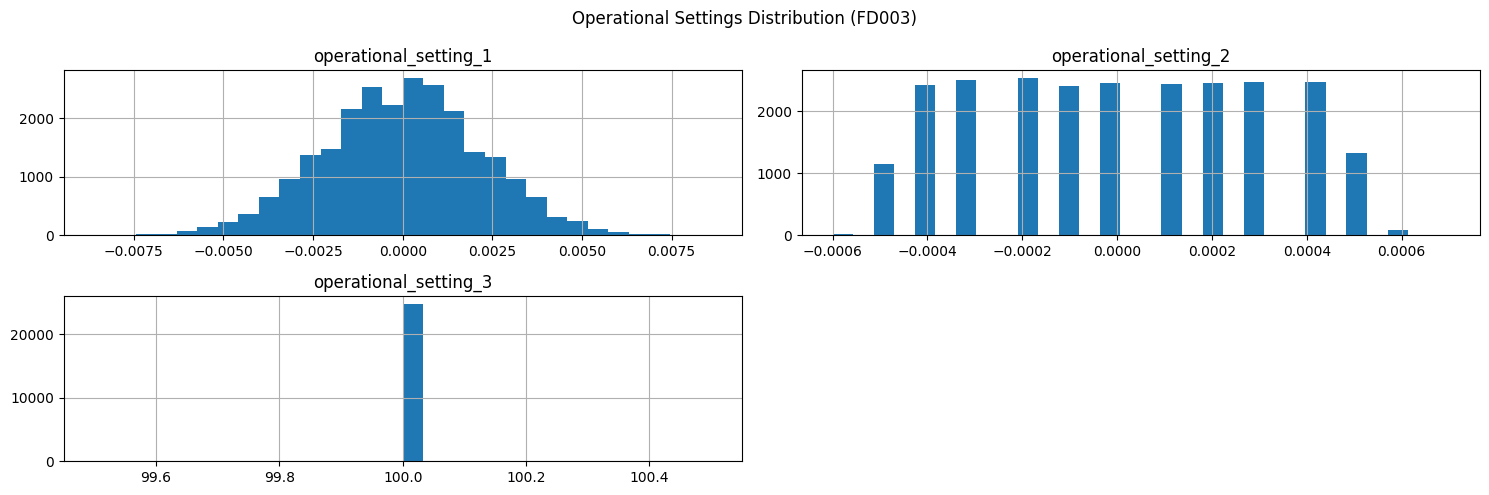

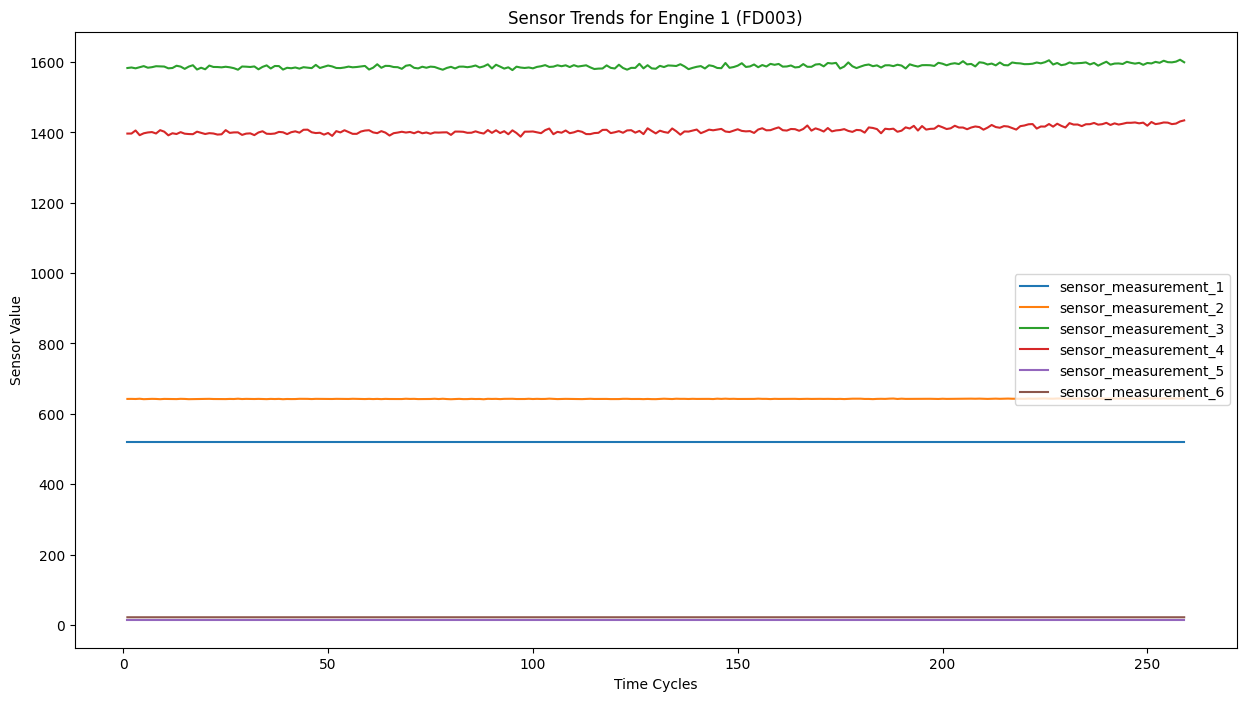


Analysis for FD004

Training data: 61249 records, 249 engines
Test data: 41214 records, 248 engines


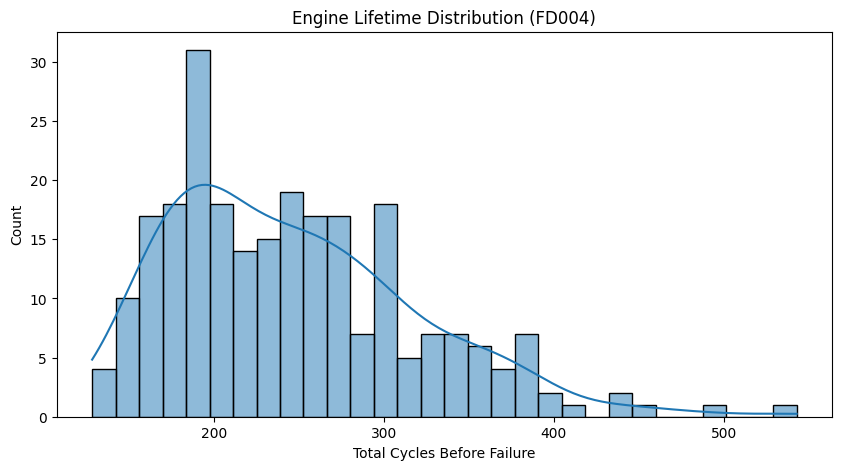

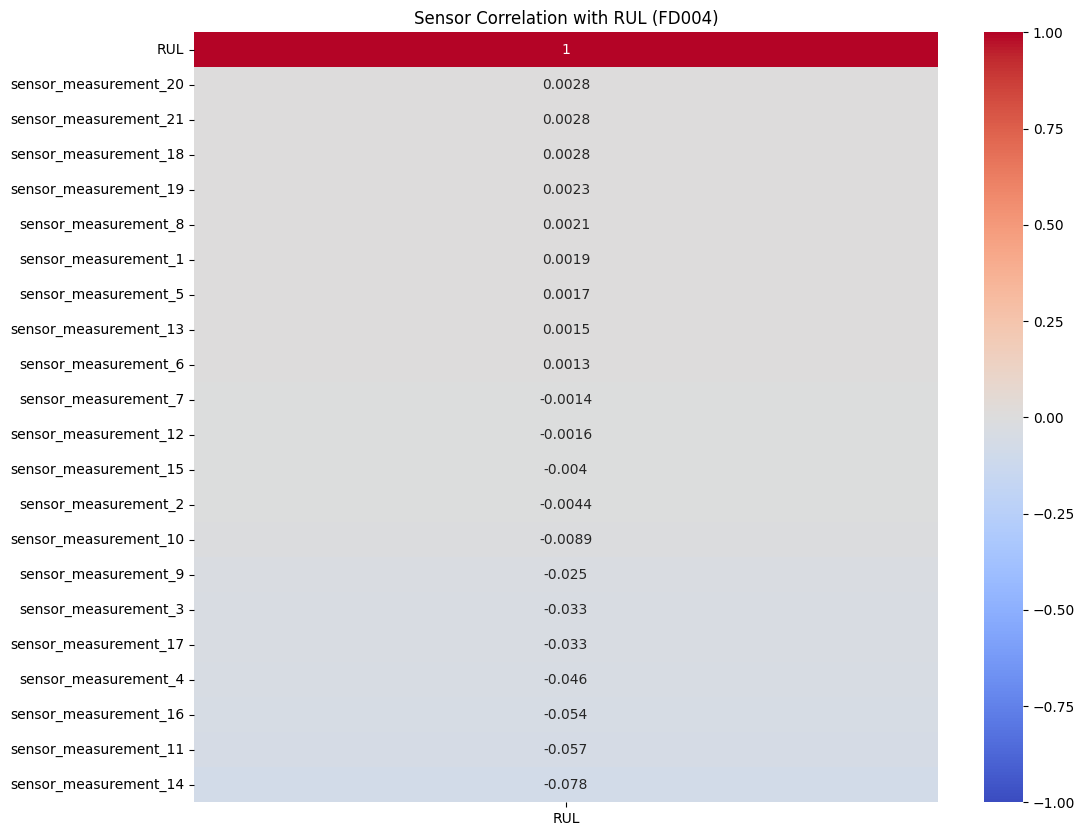

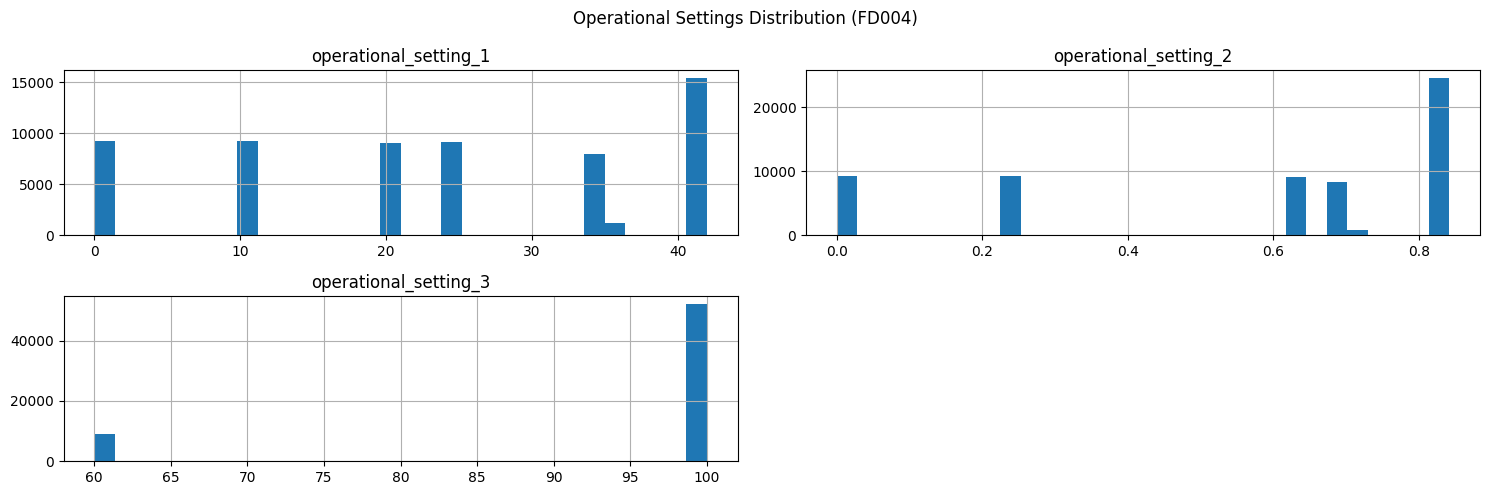

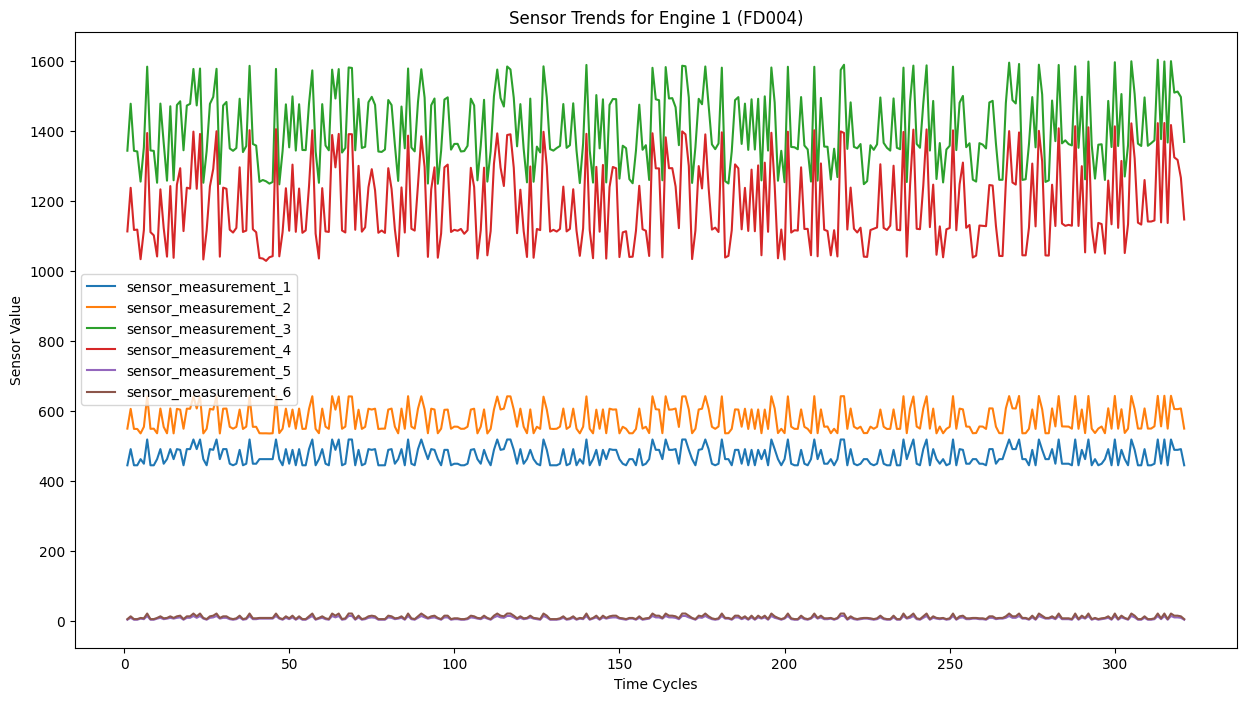

In [ ]:
# Analyze all datasets
processed_datasets = {}
for i in range(1, 5):
    train, test, rul = datasets[i]
    processed_datasets[i] = analyze_dataset(i, train.copy(), test.copy(), rul.copy())

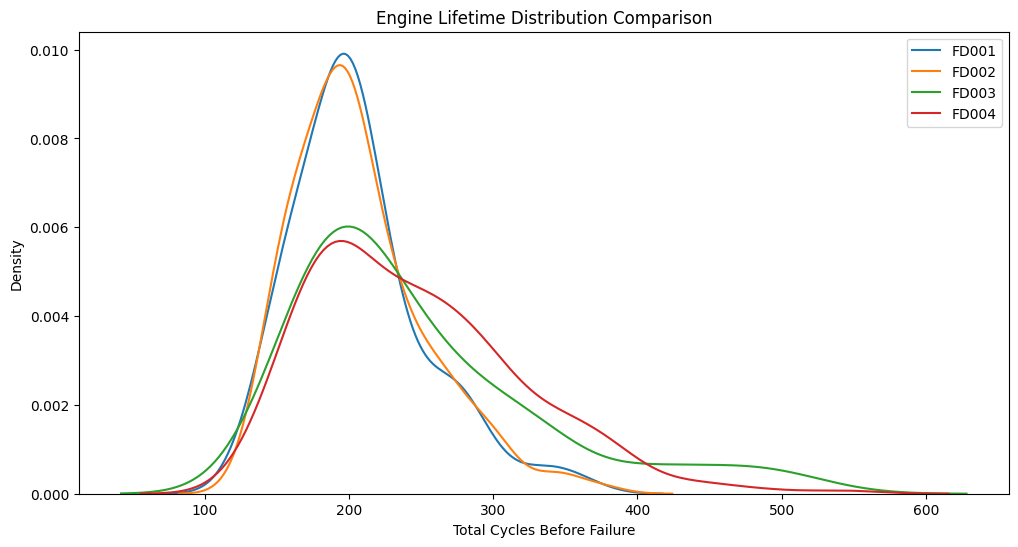

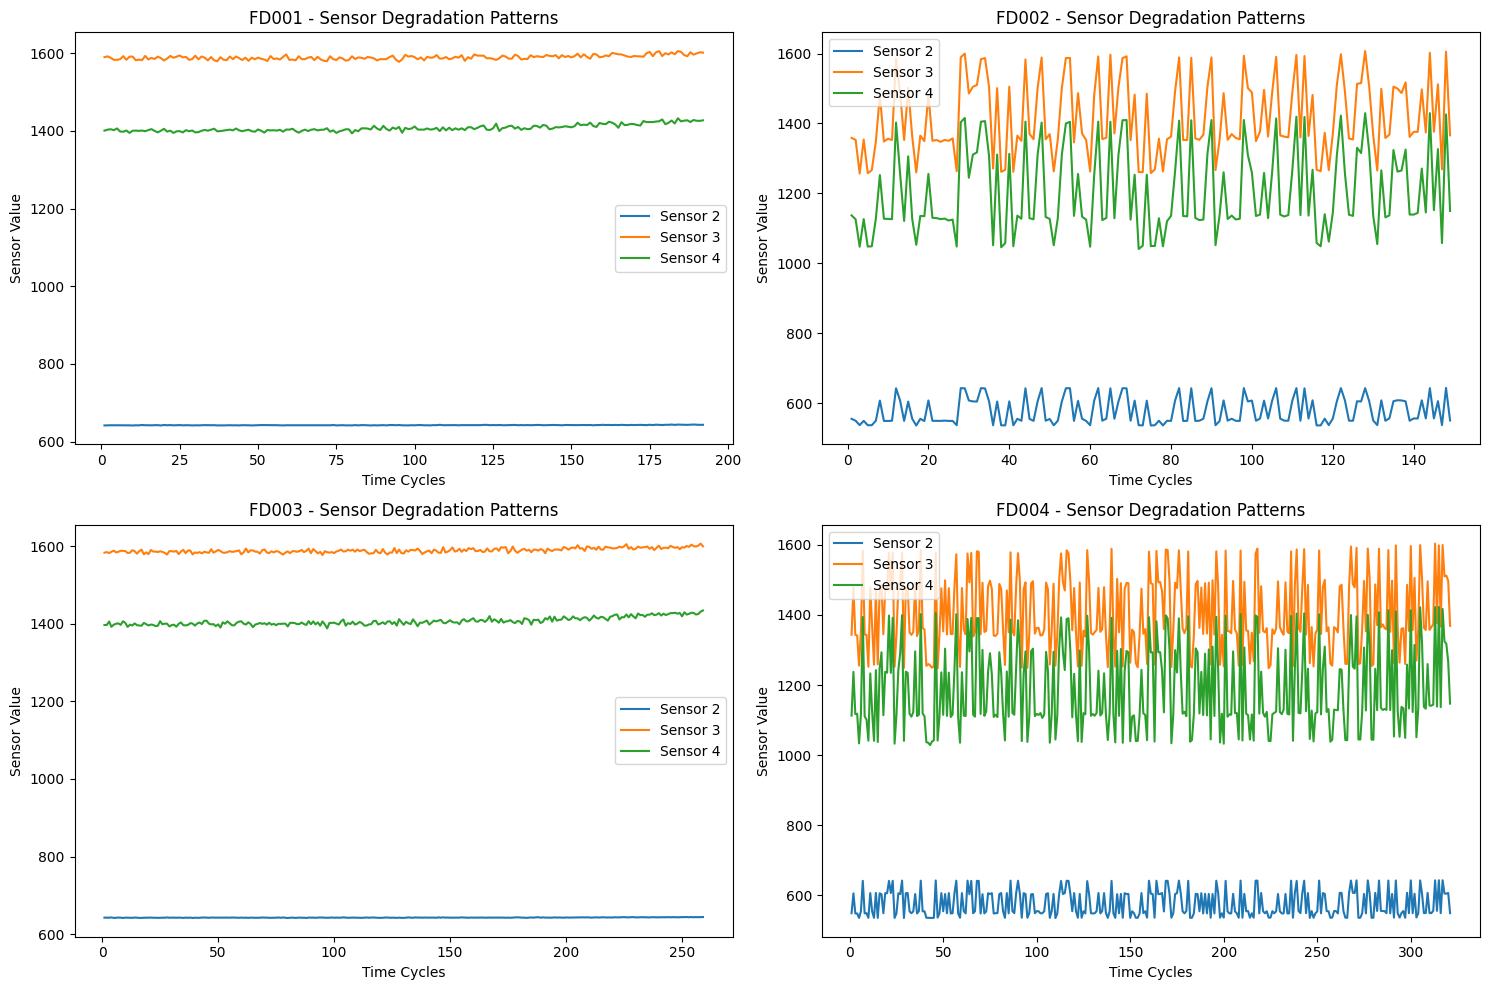

In [ ]:
# Compare engine lifetimes across datasets
plt.figure(figsize=(12, 6))
for i in range(1, 5):
    train = processed_datasets[i]
    engine_life = train.groupby('unit_number')['time_cycles'].max()
    sns.kdeplot(engine_life, label=f'FD00{i}')
plt.title('Engine Lifetime Distribution Comparison')
plt.xlabel('Total Cycles Before Failure')
plt.ylabel('Density')
plt.legend()
plt.show()

# Compare failure modes
plt.figure(figsize=(15, 10))
for i in range(1, 5):
    train = processed_datasets[i]
    sample_engine = train['unit_number'].iloc[0]
    engine_data = train[train['unit_number'] == sample_engine]

    plt.subplot(2, 2, i)
    plt.plot(engine_data['time_cycles'], engine_data['sensor_measurement_2'], label='Sensor 2')
    plt.plot(engine_data['time_cycles'], engine_data['sensor_measurement_3'], label='Sensor 3')
    plt.plot(engine_data['time_cycles'], engine_data['sensor_measurement_4'], label='Sensor 4')
    plt.title(f'FD00{i} - Sensor Degradation Patterns')
    plt.xlabel('Time Cycles')
    plt.ylabel('Sensor Value')
    plt.legend()
plt.tight_layout()
plt.show()